# Sentiment Analysis
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

- on expanded prompts
- per prompt
- aggregate per user, then per gender
- can later be correlated with code quality on the prompt level

### Problems:
- "Have fun and good luck!" gets positivity score of 0.98 but is a part of a copied assignment paper and is an errror from the parsing process ✅ fixed
- "Some prompts may only contain code, some only conversational text, the some only other parts, and some of them a mix of components." is still a leaked system prompt ✅ fixed
- "I am using datalore and I think I cannot install things." gets a negativity score of 0.81 but its actually neutral. "Why are the values so weird? because it is scaled?" get a negativity score of 0.7 but is definitely more negative.
- "Please make it tougher, I am not a baby." gets 0.69 but should be even more negative
- "I added a new plot-expanded functionality in abalone, but my import does not seem to recognize the new version of abalone.com Analytical It gives me this error to attributeErrorErrorError 1A abalone object has no attribute \'plotexpanded\'\'." gets high negativity but is neutral

## -> Mask out signal words that are neutral instead of negative in this context ("error")
## --> Mask out code parts entirely to maintain syntactical structure?
## --> use an LLM and apply different prompts or provide few shot examples?

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../../giicg.db")
prompts = pd.read_sql("SELECT ep.*, u.age, u.work_exp_years FROM expanded_prompts ep JOIN users u ON ep.user_id = u.user_id", conn)
prompts = prompts[prompts['gender'].isin(['Man (cisgender)', 'Woman (cisgender)'])]
conn.close()
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language,age,work_exp_years
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en,19-25,3.0
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en,19-25,3.0
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en,19-25,3.0
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en,19-25,3.0
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en,19-25,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en,36-40,3.0
749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de,26-30,None
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de,26-30,None
751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en,19-25,1.0


## Mask out signal words



In [2]:
import re

def mask(text):
    neutral_words = ["error", "bug", "exception", "fail", "fails", "FAISS", "invalid", "warning", "imbalance problem", "blocks", "warnings", "errors"]
    for w in neutral_words:
        text = re.sub(rf'\b{re.escape(w)}\b', 'placeholder', text, flags=re.IGNORECASE)
    return text

prompts['conversational'] = prompts['conversational'].apply(mask)
prompts



,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language,age,work_exp_years
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en,19-25,3.0
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en,19-25,3.0
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en,19-25,3.0
3,1135,55,user,what is FAISS,what is placeholder,,,Man (cisgender),6,en,19-25,3.0
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en,19-25,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en,36-40,3.0
749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de,26-30,None
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de,26-30,None
751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en,19-25,1.0


In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
import torch

def load_model(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    config = AutoConfig.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path)
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    return model, tokenizer, config

def analyze_sentiment(text, model, tokenizer, max_length=512):
    """
    Analyze sentiment of text with proper length handling
    """
    try:
        # Ensure text is a string and handle empty/None values
        if not text or not isinstance(text, str):
            return [0.33, 0.33, 0.34]  # neutral default

        # Tokenize with proper truncation and padding
        encoded_input = tokenizer(
            text,
            return_tensors='pt',
            max_length=max_length,
            truncation=True,
            padding=True
        )

        # Run the model
        with torch.no_grad():  # Disable gradient computation for efficiency
            output = model(**encoded_input)

        # Extract logits and apply softmax
        logits = output.logits[0].detach().numpy()
        scores = softmax(logits)

        return scores.tolist()

    except Exception as e:
        print(f"Error processing text: {str(e)}")
        return [0.33, 0.33, 0.34]  # neutral default on error


def process_row(text):
    scores = analyze_sentiment(text, model, tokenizer)
    return pd.Series(scores, index=['negative', 'neutral', 'positive'])


path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
model, tokenizer, config = load_model(path)
prompts[['negative', 'neutral', 'positive']] = prompts['conversational'].apply(process_row)
prompts['sentiment'] = prompts[['negative', 'neutral', 'positive']].idxmax(axis=1)


prompts


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language,age,work_exp_years,negative,neutral,positive,sentiment
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en,19-25,3.0,0.027240,0.880042,0.092718,neutral
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en,19-25,3.0,0.032637,0.902418,0.064945,neutral
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en,19-25,3.0,0.289665,0.645016,0.065319,neutral
3,1135,55,user,what is FAISS,what is placeholder,,,Man (cisgender),6,en,19-25,3.0,0.223797,0.681688,0.094515,neutral
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en,19-25,3.0,0.057809,0.881504,0.060688,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en,36-40,3.0,0.015253,0.878982,0.105765,neutral
749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de,26-30,None,0.079067,0.861176,0.059757,neutral
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de,26-30,None,0.509511,0.466035,0.024453,negative
751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en,19-25,1.0,0.159805,0.793475,0.046720,neutral


## Collect per user
Proportion of negative, neutral and positive prompts per user

In [4]:
proportion_per_user = (
    prompts.fillna({'work_exp_years': 'None'})
    .groupby(['user_id', 'gender', 'age', 'work_exp_years'])['sentiment']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
)
proportion_per_user


sentiment,user_id,gender,age,work_exp_years,negative,neutral,positive
0,6,Man (cisgender),19-25,3.0,0.000000,1.000000,0.000000
1,8,Man (cisgender),19-25,1.0,0.000000,1.000000,0.000000
2,11,Woman (cisgender),26-30,1.0,0.090909,0.909091,0.000000
3,15,Man (cisgender),26-30,6.0,0.666667,0.333333,0.000000
4,16,Woman (cisgender),19-25,None,0.040000,0.880000,0.080000
5,25,Man (cisgender),26-30,6.0,0.000000,1.000000,0.000000
6,28,Woman (cisgender),31-35,5.0,0.136364,0.727273,0.136364
7,29,Woman (cisgender),26-30,None,0.500000,0.500000,0.000000
8,31,Man (cisgender),36-40,22.0,0.000000,1.000000,0.000000
9,34,Man (cisgender),51-60,20.0,0.106061,0.893939,0.000000


## Plot

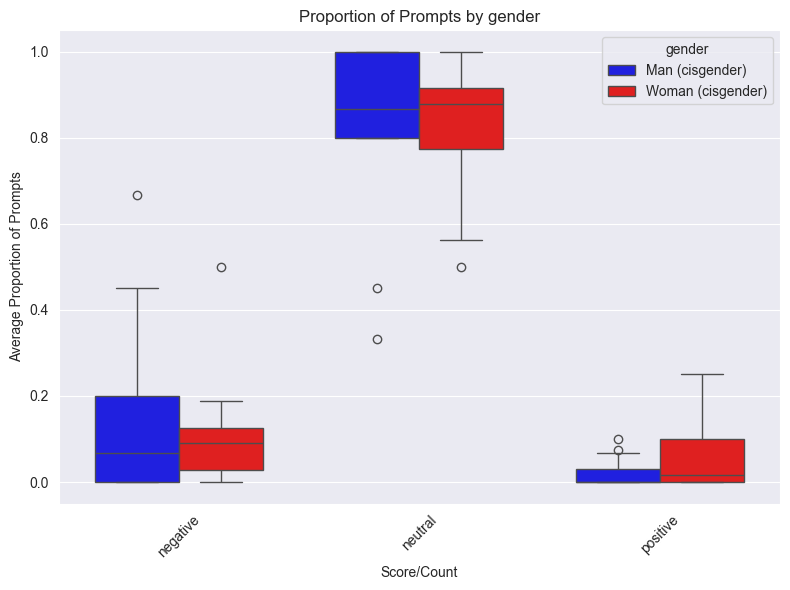

,user_id,gender,age,work_exp_years,sentiment,proportion
0,6,Man (cisgender),19-25,3.0,negative,0.000000
1,8,Man (cisgender),19-25,1.0,negative,0.000000
2,11,Woman (cisgender),26-30,1.0,negative,0.090909
3,15,Man (cisgender),26-30,6.0,negative,0.666667
4,16,Woman (cisgender),19-25,None,negative,0.040000
...,...,...,...,...,...,...
79,88,Man (cisgender),19-25,None,positive,0.000000
80,89,Woman (cisgender),26-30,6.0,positive,0.129032
81,90,Woman (cisgender),26-30,2.0,positive,0.000000
82,91,Man (cisgender),31-35,6.0,positive,0.074074


In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

gender_palette = {'Woman (cisgender)': 'red', 'Man (cisgender)': 'blue'}
age_palette = {'19-25': 'red', '26-30': 'orange', '31-35': 'yellow', '36-40': 'green', '41-50': 'blue', '51-60': 'purple'}


def make_long_df(id_vars, value_vars, x_label, y_label):
    return proportion_per_user.melt(
        id_vars=id_vars,
        value_vars=value_vars,
        var_name=x_label,
        value_name=y_label
)


def box_plot(long_df, x_label, y_label, hue_variable, palette):
    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=long_df,
        x=x_label,
        y=y_label,
        hue=hue_variable,
        palette=palette,
        width=0.7
    )

    plt.title(f'Proportion of Prompts by {hue_variable}')
    plt.ylabel('Average Proportion of Prompts')
    plt.xlabel('Score/Count')
    plt.legend(title=hue_variable)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

long = make_long_df(['user_id', 'gender', 'age', 'work_exp_years'], ['negative', 'neutral', 'positive'], 'sentiment', 'proportion')
box_plot(long, 'sentiment', 'proportion', 'gender', gender_palette)
long

## Statistical Tests

## Groupwise

In [8]:
from helpers.make_latex_table import create_latex_tables
from statsmodels.stats.multitest import multipletests
from helpers.statistical_tests import compare_genders

def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs= []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_genders(df, col, one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['m_female'])
        male_means.append(result['m_male'])
        female_stds.append(result['std_female'])
        male_stds.append(result['std_male'])
        n_females.append(result['n_female'])
        n_males.append(result['n_male'])
        nonzero_females.append(result['hits_female'])
        nonzero_males.append(result['hits_male']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results

results = groupwise_comparison_with_correction(proportion_per_user, ['negative', 'neutral', 'positive'])
results = results.sort_values(by="p_value", ascending=True)
create_latex_tables(results, "sentiment_stats.tex", "sentiment_effsize.tex")
results

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci
2,positive,Mann-Whitney U,greater,False,None,66.5,0.110821,0.332462,0.016393,0.000000,0.077626,0.035263,13,15,7,4,-0.317949,RBC,"[-0.69, 0.04]"
1,neutral,Mann-Whitney U,greater,False,None,105.0,0.744113,1.000000,0.880000,0.866667,0.156707,0.202065,13,15,13,15,0.076923,RBC,"[-0.36, 0.52]"
0,negative,Mann-Whitney U,greater,False,None,97.0,1.000000,1.000000,0.090909,0.066667,0.131738,0.191790,13,15,10,9,-0.005128,RBC,"[-0.45, 0.41]"


### ANOVA

In [7]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
#
# model = ols('proportion ~ gender * sentiment', data=long).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# display(anova_table)
#
# plt.figure(figsize=(8,6))
# sns.pointplot(
#     data=long,
#     x='sentiment',
#     y='proportion',
#     hue='gender',
#     ci='sd',
#     dodge=True
# )
# plt.title('Proportion of each sentiment per user, split by gender')
# plt.show()

